In [78]:
import os
import numpy as np
import time
import copy
import sys

import matplotlib
import matplotlib.pyplot as plt

import skimage.transform

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import cp2k_utilities as cu

In [79]:
#folder = "/home/kristjan/local_work/asetk_example1/for_restart_file/"
#file_basis_set = folder + "BR"
#file_xyz = folder + "anthracene.xyz"
#file_restart = folder + "ANTHRACENE-RESTART.wfn"
#file_cp2k_inp = folder + "cp2k.inp"
#file_cp2k_out = folder + "cp2k.out"

#folder = "/home/kristjan/local_work/cp2k_na_ribbon/scf/"
#file_cp2k_inp = folder + "cp2k.inp"
#file_cp2k_out = folder + "cp2k.out"
#file_basis_set = folder + "BR"
#file_xyz = folder + "p_opt_centered.xyz"
#file_restart = folder + "PROJ-RESTART.wfn"
#file_hartree = folder + "PROJ-HART-v_hartree-1_0.cube"

folder = "/home/kristjan/local_work/precursor_9agnr/"
file_cp2k_inp = folder + "cp2k.inp"
file_cp2k_out = folder + "cp2k.out"
file_basis_set = folder + "BR"
file_xyz = folder + "p.xyz"
file_restart = folder + "PROJ-RESTART.wfn"
file_hartree = folder + "V_HARTREE-v_hartree-1_0.cube"

In [80]:
emin = -0.5
emax =  0.5

In [81]:
time1 = time.time()
elem_basis_names, cell = cu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time1 = time.time()
fermi = cu.read_fermi_from_cp2k_out(file_cp2k_out)
print("Fermi energy: %.6f" % fermi)
print("Read cp2k out: %.3f" % (time.time()-time1))

time1 = time.time()
at_positions, at_elems = cu.read_atoms(file_xyz)
print("Read xyz: %.3f" % (time.time()-time1))

time1 = time.time()
basis_sets = cu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time1))

# RESTART FILE

time1 = time.time()
morb_composition, morb_energies, morb_occs, ref_energy, i_homo = cu.load_restart_wfn_file(
                                                                            file_restart, emin, emax, fermi)
print("Found %d orbitals" % len(morb_energies))
print("Read restart: %.3f" % (time.time()-time1))


Read cp2k input: 0.001
Fermi energy: -1.278832
Read cp2k out: 0.001
Read xyz: 0.035
Read basis sets: 0.008
First molecular index in energy range:  5075
Found 152 orbitals
Read restart: 12.900


In [82]:
# HARTREE CUBE

time1 = time.time()
hart_cube_data = cu.read_cube_file(file_hartree)
hart_cube = hart_cube_data[-1]
hart_cell = hart_cube_data[5]
print("Read hartree: %.3f" % (time.time()-time1))

Read hartree: 9.055


In [83]:
# Define the morb evaluation region

height_above_atoms = 4.0 # angstroms

top_atom_z = np.max(at_positions[:, 2]) # Bohr
z_top = top_atom_z + height_above_atoms*ang_2_bohr
carb_positions = at_positions[np.array(at_elems)[:, 0] == 'C']
z_bottom = np.min(carb_positions[:, 2]) - 1.0*ang_2_bohr# Bohr

eval_reg_size = np.array([cell[0], cell[1], z_top-z_bottom])

# Define real space grid
# Cp2k chooses close to 0.08 angstroms (?)
step = 0.25
step *= ang_2_bohr

eval_reg_size_n = (np.round(eval_reg_size/step)).astype(int)

dv = eval_reg_size/eval_reg_size_n

# increase the z size such that top plane exactly matches z_top
eval_reg_size[2] += dv[2]
eval_reg_size_n[2] += 1

z_arr = np.arange(0.0, eval_reg_size[2], dv[2])+z_bottom

In [12]:
morb_grids = cu.calc_morbs_in_region(eval_reg_size, eval_reg_size_n, z_bottom,
                         at_positions, at_elems,
                         basis_sets, morb_composition, pbc_box_size = 18.0)

Eval cell:    [ 78.68304769  77.87602074  18.98688725] [167 165  40]
Local cell:  [ 34.01507026  34.01507026  18.98688725] [73 73 40]
---- Setup: 0.0092
---- Radial calc time : 197.801742
---- Spherical calc time : 32.967821
---- Loc -> loc_morb time : 1372.432141
---- loc_morb -> glob time : 101.466996
---- Total time: 1733.6030


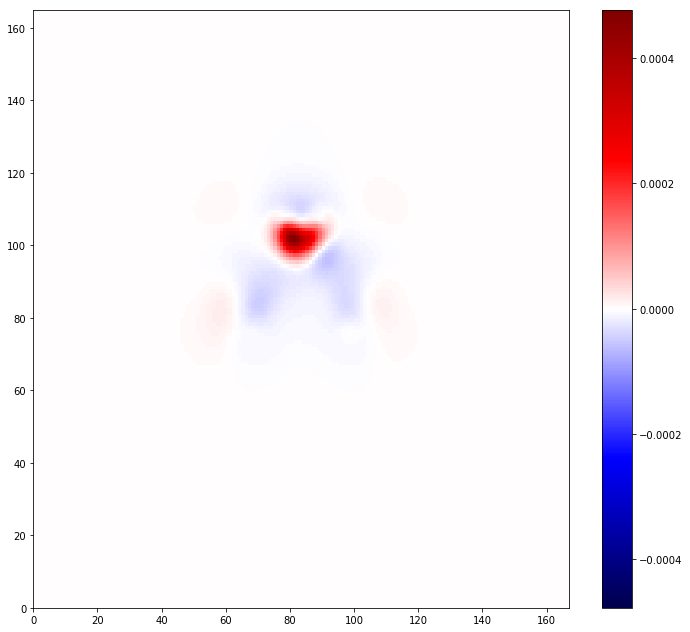

In [25]:
height = 0.5

top_atom_z = np.max(at_positions[:, 2])
plane_z = top_atom_z + height*ang_2_bohr

plane_index = int(np.round((plane_z - z_bottom)/dv[2]))

plt.figure(figsize=(12, int(eval_reg_size[1]/eval_reg_size[0]*12)))
plot_data = morb_grids[i_homo-8][:, :, plane_index].T
max_val = np.max(plot_data)
plt.pcolormesh(plot_data, vmax=max_val, vmin=-max_val, cmap='seismic')
plt.colorbar()
plt.show()

# Save all relevant data to a .npz (cross platform) file

In [ ]:
data_file = "/home/kristjan/local_work/sts_datafiles/prec_9agnr"

time0 = time.time()
np.savez(data_file, morb_grids, morb_energies, dv)
print(time.time() - time0)

# Load .npz

In [35]:
data_file = "/home/kristjan/local_work/precursor_9agnr/morb_grid.npz"
npzfile = np.load(data_file)
npzfile.files

['morb_grids', 'morb_energies', 'dv', 'z_arr', 'elim', 'ref_energy']

In [48]:
morb_grids = npzfile['morb_grids']
morb_energies = npzfile['morb_energies']
dv = npzfile['dv']
z_arr = npzfile['z_arr']
elim = npzfile['elim']
ref_energy = npzfile['ref_energy']

z_top = z_arr[-1]
eval_reg_size_n = np.shape(morb_grids[0])
eval_reg_size = dv * eval_reg_size_n

In [65]:
i_homo = 0
for i, en in enumerate(morb_energies):
    if en > 0.0:
        i_homo = i - 1
        break
    if np.abs(en) < 1e-6:
        i_homo = i
i_homo

24

# Extrapolating

From top of the orbital evaluation region

In [86]:
extent = 8.0 # angstroms

In [91]:
extrap_plane = 2.0

In [101]:
time1 = time.time()
hart_cube = hart_cube_data[-1]
hart_cell = hart_cube_data[5]
hart_atomic_pos = hart_cube_data[-2]
print("Read hartree: %.3f" % (time.time()-time1))

topmost_atom_z = np.max(hart_atomic_pos[:, 2])*ang_2_bohr # Angstrom
hart_plane_z = extrap_plane + topmost_atom_z
hart_plane_index = int(np.round(hart_plane_z/hart_cell[2, 2]*np.shape(hart_cube)[2]))

print("#####", topmost_atom_z, hart_plane_z, hart_plane_index)
print("#####", hart_cell)

Read hartree: 0.000
##### 49.127122 51.127122 383
##### [[ 41.70393632   0.           0.        ]
 [  0.          41.27610766   0.        ]
 [  0.           0.          39.99992326]]


In [102]:
z_top

56.686026659421344

min: 4.5845; max: 4.9203; avg: 4.8362 (eV)


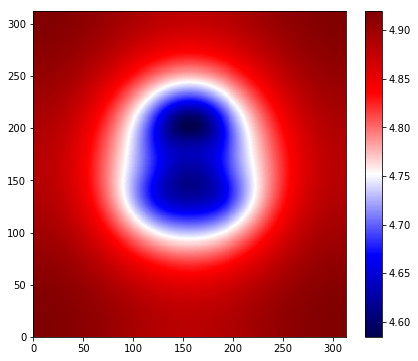

In [87]:
hart_plane_index = int(np.round(z_top/ang_2_bohr/hart_cell[2, 2]*np.shape(hart_cube)[2]))
hart_plane = hart_cube[:, :, hart_plane_index] - ref_energy/hart_2_ev

print("min: %.4f; max: %.4f; avg: %.4f (eV)" % (np.min(hart_plane)*hart_2_ev,
                                                np.max(hart_plane)*hart_2_ev,
                                                np.mean(hart_plane)*hart_2_ev))

fig_size = 6
plt.figure(figsize=(fig_size*hart_plane.shape[0]/hart_plane.shape[1]+1.0, fig_size))
plt.pcolormesh(hart_plane.T*hart_2_ev, cmap='seismic')
plt.colorbar()
plt.show()

In [49]:
def extrapolate_morbs(morb_grids, morb_energies, dv, extent, hart_plane, use_weighted_avg=True):
    # NB: everything in hartree units!
    extrap_planes = []
    time1 = time.time()

    num_morbs = np.shape(morb_grids)[0]
    extrap_morbs = np.zeros((num_morbs, eval_reg_size_n[0], eval_reg_size_n[1], int(extent*ang_2_bohr/dv[2])))
    
    for morb_index in range(num_morbs):
        
        morb_plane = morb_grids[morb_index][:, :, -1]
        
        if use_weighted_avg:
            # weigh the hartree potential by the molecular orbital
            density_plane = morb_plane**2
            density_plane /= np.sum(density_plane)
            weighted_hartree = density_plane * skimage.transform.resize(hart_plane, density_plane.shape, mode='reflect')
            hartree_avg = np.sum(weighted_hartree)
        else:
            hartree_avg = np.mean(hart_plane)

        energy = morb_energies[morb_index]/hart_2_ev
        if energy > hartree_avg:
            print("Warning: unbound state, can't extrapolate! index: %d. Exiting." % morb_index)
            break

        fourier = np.fft.rfft2(morb_plane)
        # NB: rfft2 takes REAL fourier transform over last (y) axis and COMPLEX over other (x) axes
        # dv in BOHR, so k is in 1/bohr
        kx_arr = 2*np.pi*np.fft.fftfreq(morb_plane.shape[0], dv[0])
        ky_arr = 2*np.pi*np.fft.rfftfreq(morb_plane.shape[1], dv[1])

        kx_grid, ky_grid = np.meshgrid(kx_arr, ky_arr,  indexing='ij')

        prefactors = np.exp(-np.sqrt(kx_grid**2 + ky_grid**2 - 2*(energy - hartree_avg))*dv[2])
        
        for iz in range(np.shape(extrap_morbs)[3]):
            fourier *= prefactors
            extrap_morbs[morb_index, :, :, iz] = np.fft.irfft2(fourier, morb_plane.shape)
        
    print("Time: %.3f s"%(time.time()-time1))
    return extrap_morbs

In [50]:
extrap_morbs = extrapolate_morbs(morb_grids, morb_energies, dv, extent, hart_plane, use_weighted_avg=True)

Time: 0.790 s


In [56]:
total_morb_grids = np.concatenate((morb_grids, extrap_morbs), axis=3)

# In bohr and wrt topmost atom
total_z_arr = np.arange(0.0, np.shape(total_morb_grids)[3]*dv[2], dv[2]) + z_arr[0]

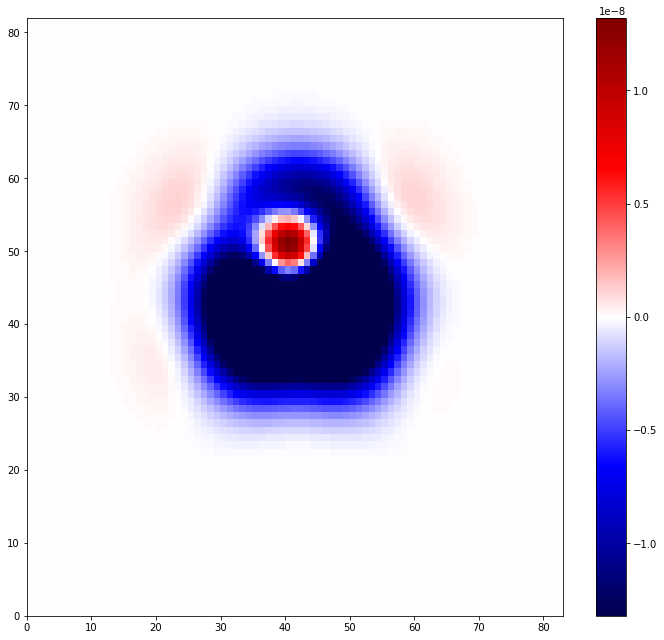

In [75]:
height = 7.0

plane_z = height*ang_2_bohr

plane_index = int(np.round((plane_z - total_z_arr[0])/dv[2]))

plt.figure(figsize=(12, int(eval_reg_size[1]/eval_reg_size[0]*12)))
plot_data = total_morb_grids[i_homo-8][:, :, plane_index].T
max_val = np.max(plot_data)
plt.pcolormesh(plot_data, vmax=max_val, vmin=-max_val, cmap='seismic')
plt.colorbar()
plt.show()

1.0


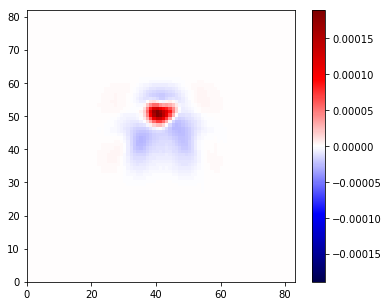

1.5


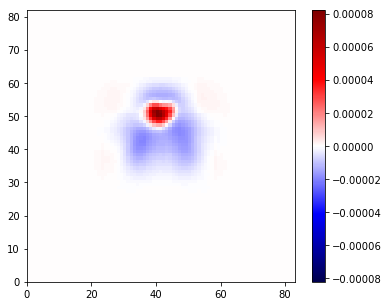

2.0


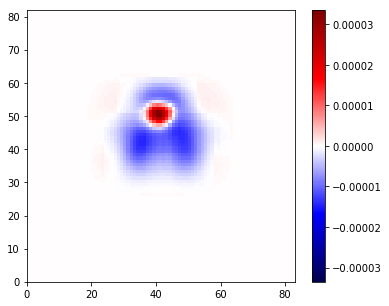

2.5


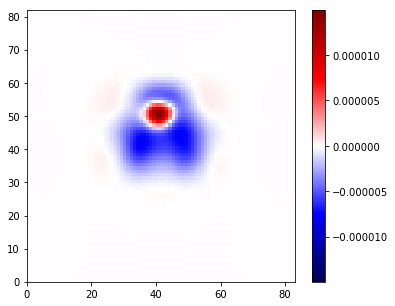

3.0


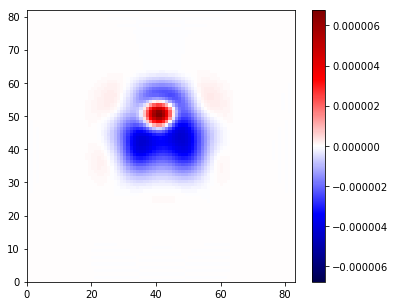

3.5


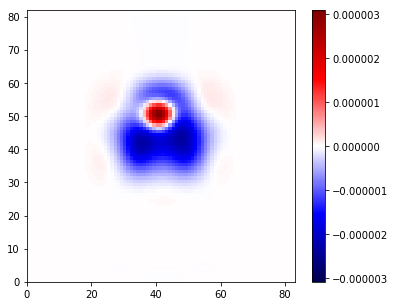

4.0


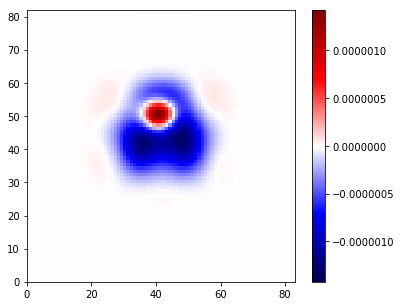

4.5


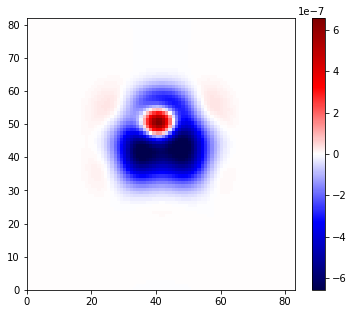

5.0


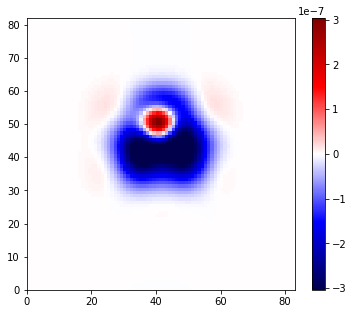

5.5


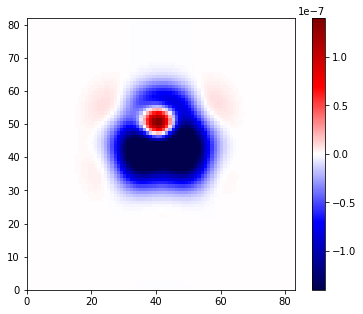

6.0


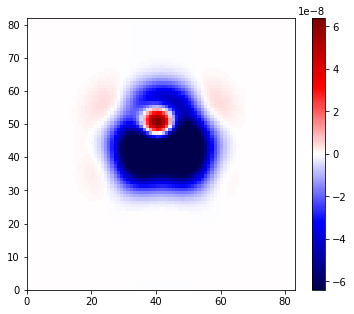

6.5


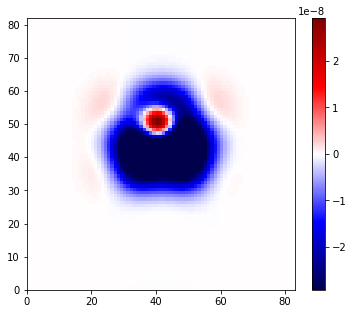

7.0


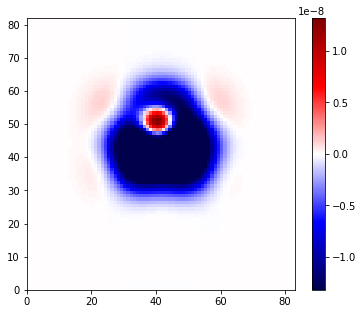

7.5


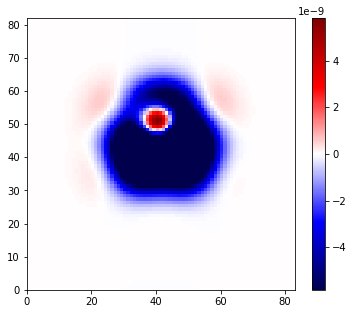

8.0


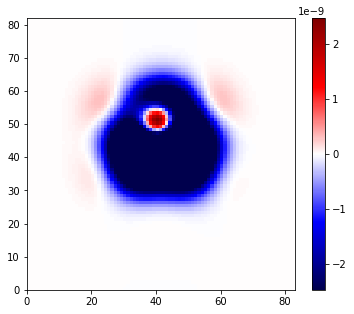

8.5


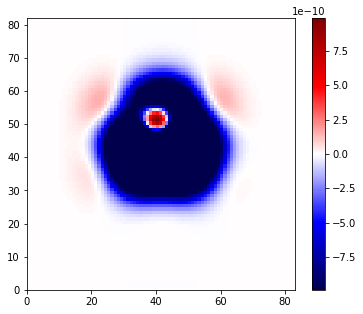

9.0


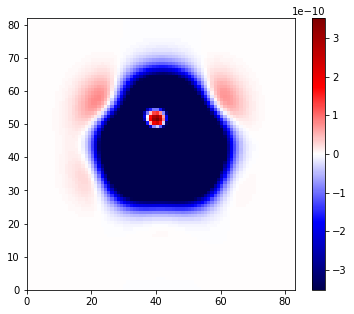

9.5


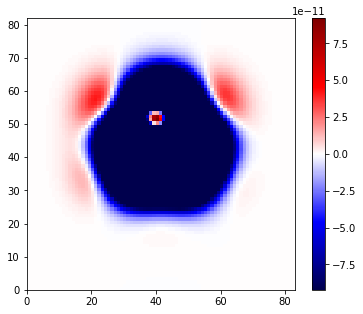

In [76]:
for height in np.arange(1.0, 10.0, 0.5):

    print(height) # wrt to the topmost atom

    plane_index = int(np.round((height*ang_2_bohr - total_z_arr[0])/dv[2]))

    plt.figure(figsize=(6, int(eval_reg_size[1]/eval_reg_size[0]*6)))
    plot_data = total_morb_grids[i_homo-8][:, :, plane_index].T
    max_val = np.max(plot_data)
    plt.pcolormesh(plot_data, vmax=max_val, vmin=-max_val, cmap='seismic')
    plt.colorbar()
    plt.show()

# Summing charge densities according to bias voltages

In [38]:
bias_arr = [-0.5, -0.3, -0.25, 0.3, 0.5]

In [39]:
charge_dens_arr = []
for bias in bias_arr:
    charge_dens = np.zeros(np.shape(total_morb_grids[0]))
    for imo, morb_grid in enumerate(total_morb_grids):
        if morb_energies[imo] > np.max([0.0, bias]):
            break
        if morb_energies[imo] >= np.min([0.0, bias]):
            charge_dens += morb_grid**2
    charge_dens_arr.append(charge_dens)

# Constant height STM pictures

In [77]:
height = 5.0

bias_index = 3

plane_index = int(np.round((height*ang_2_bohr - total_z_arr[0])/dv[2]))

plt.figure(figsize=(12, int(eval_reg_size[1]/eval_reg_size[0]*12)))
plot_data = charge_dens_arr[bias_index][:, :, plane_index].T
max_val = np.max(plot_data)
plt.pcolormesh(plot_data, vmax=max_val, vmin=0, cmap='gist_heat')
plt.colorbar()
plt.show()

NameError: name 'charge_dens_arr' is not defined

# Constant current STM pictures

In [41]:
def get_isosurf(data, value, z_vals, interp=True):
    rev_data = data[:, :, ::-1]
    rev_z_vals = z_vals[::-1]
    
    indexes = np.argmax(rev_data > value, axis=2)
    
    # IF indexes are 0, then it probably didn't find the correct value
    # And set it as the bottom surface
    indexes[indexes == 0] = len(z_vals) - 1
    
    if interp:
        z_val_plane = np.ones(np.shape(rev_data)[0:2])*z_vals[0]
        for ix in range(np.shape(rev_data)[0]):
            for iy in range(np.shape(rev_data)[1]):
                ind = indexes[ix, iy]
                if ind == len(z_vals) - 1:
                    continue
                val_g = rev_data[ix, iy, ind]
                z_val_g = rev_z_vals[ind]
                val_s = rev_data[ix, iy, ind - 1]
                z_val_s = rev_z_vals[ind - 1]
                z_val_plane[ix, iy] = (value - val_s)/(val_g - val_s)*(z_val_g - z_val_s) + z_val_s
        return z_val_plane
    
    return rev_z_vals[indexes]

In [42]:
charge_dens_arr[0][:, :, 0]

array([[ 0.00020516,  0.00019538,  0.00017233, ...,  0.0001469 ,
         0.00017401,  0.00019664],
       [ 0.00019784,  0.00018878,  0.00016739, ...,  0.00014377,
         0.00016901,  0.00018997],
       [ 0.00017907,  0.00017177,  0.0001545 , ...,  0.00013556,
         0.00015603,  0.00017285],
       ..., 
       [ 0.0001559 ,  0.00015056,  0.00013811, ...,  0.00012501,
         0.00013969,  0.00015162],
       [ 0.00017907,  0.00017178,  0.00015451, ...,  0.00013555,
         0.00015602,  0.00017284],
       [ 0.00019784,  0.00018879,  0.0001674 , ...,  0.00014376,
         0.000169  ,  0.00018997]])

In [74]:
const_cur_imag = get_isosurf(charge_dens_arr[2], 1e-6, total_z_arr, True)

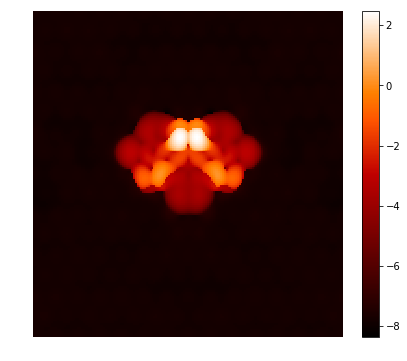

In [75]:
plt.figure(figsize=(eval_reg_size[1]/eval_reg_size[0]*6+1, 6))
plot_data = const_cur_imag.T
max_val = np.max(plot_data)

plt.pcolormesh(plot_data, vmax=max_val, cmap='gist_heat')
plt.colorbar()
plt.axis('off')
plt.show()

In [65]:
np.min(plot_data)

-10.455169350909348

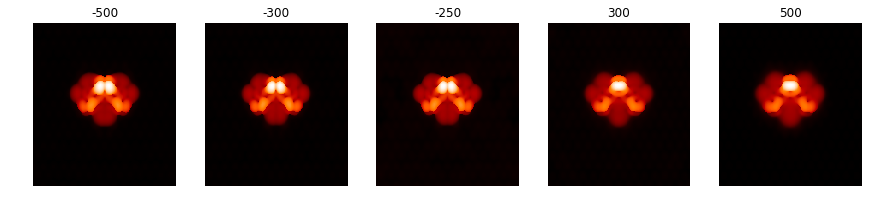

In [58]:
plt.figure(figsize=(eval_reg_size[1]/eval_reg_size[0]*3*5, 3))

for iv, volt in enumerate(bias_arr):
    plt.subplot(1, len(bias_arr), iv+1)
    
    const_cur_imag = get_isosurf(charge_dens_arr[iv], 5e-7, total_z_arr, True)
    
    plot_data = const_cur_imag.T
    max_val = np.max(plot_data)

    plt.pcolormesh(plot_data, vmax=max_val, cmap='gist_heat')
    plt.title("%.0f"%(volt*1000))
    plt.axis('off')

#plt.savefig('./fig/cc_stm.png', dpi=400, bbox_inches='tight')
plt.show()

# Scanning Tunnelling Spectroscopy

In [556]:
height = 5.0

plane_index = int(np.round((height*ang_2_bohr - total_z_arr[0])/dv[2]))


de = 0.05 # eV
        
e_arr = np.arange(emin, emax+de, de)

x_arr_ang = np.arange(0.0, eval_reg_size[0], dv[0])/ang_2_bohr
y_arr_ang = np.arange(0.0, eval_reg_size[1], dv[1])/ang_2_bohr

x_e_grid, y_e_grid, e_grid = np.meshgrid(x_arr_ang, y_arr_ang, e_arr, indexing='ij')

def calculate_ldos(de, fwhm, broad_type='g'):

    def lorentzian(x):
        gamma = 0.5*fwhm
        return gamma/(np.pi*(x**2+gamma**2))

    def gaussian(x):
        sigma = fwhm/2.3548
        return np.exp(-x**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

    pldos = np.zeros((eval_reg_size_n[0], eval_reg_size_n[1], len(e_arr)))

    for i_mo, morb_grid in enumerate(total_morb_grids):
        en = morb_energies[i_mo]
        
        morb_plane = morb_grid[:, :, plane_index]**2
        
        if broad_type == 'l':
            morb_ldos_broad = np.einsum('ij,k', morb_plane, lorentzian(e_arr - en))
        else:
            morb_ldos_broad = np.einsum('ij,k', morb_plane, gaussian(e_arr - en))
        
        pldos += morb_ldos_broad
    
    return pldos


In [557]:
pldos = calculate_ldos(de, 0.1)

-0.5
2.82843165774e-10
4.88444127088e-34


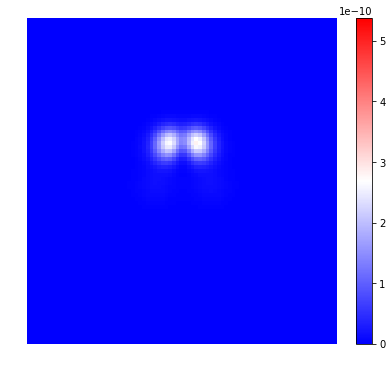

-0.45
1.9721893754e-10
3.6964649916e-34


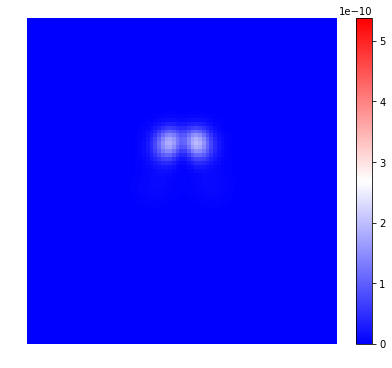

-0.4
1.03200306942e-10
5.64530662046e-34


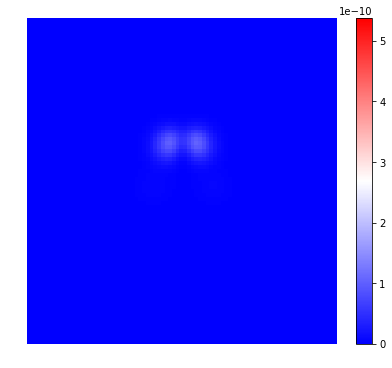

-0.35
1.20111848459e-10
1.0314462973e-33


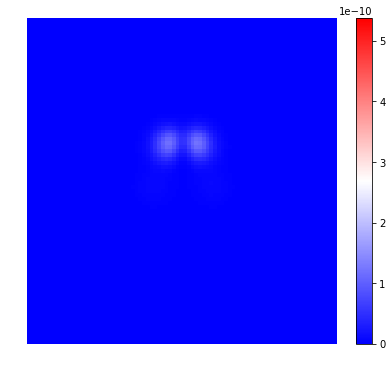

-0.3
7.36982843449e-11
1.2958824233e-33


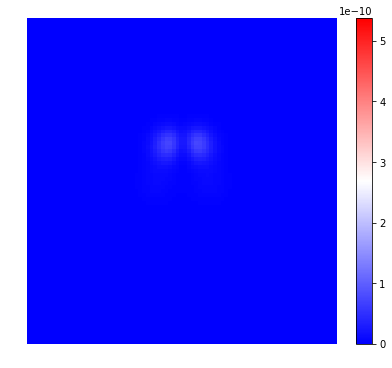

-0.25
1.12707571727e-10
3.54475311856e-33


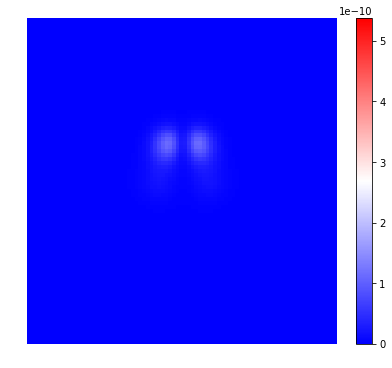

-0.2
1.70865940579e-10
4.05107584426e-33


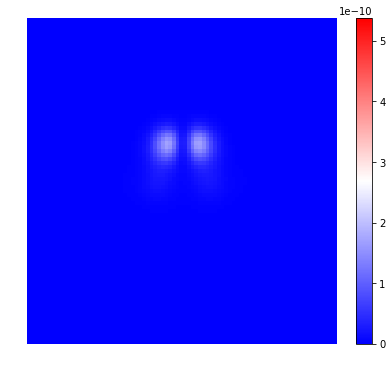

-0.15
1.00558434239e-10
2.59925596542e-33


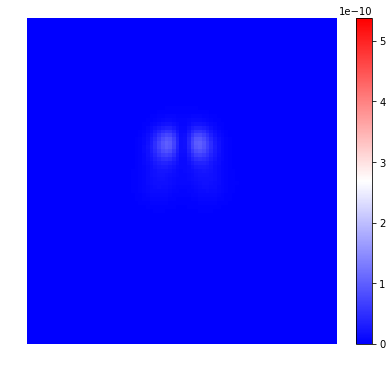

-0.1
7.59417779538e-11
5.61247806388e-33


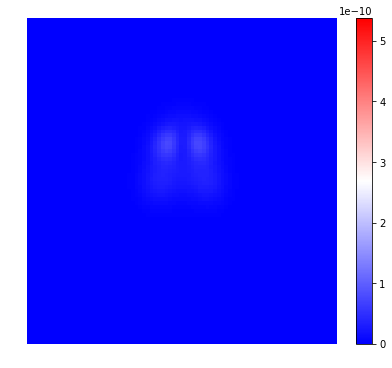

-0.05
8.66606134345e-11
8.64939098598e-33


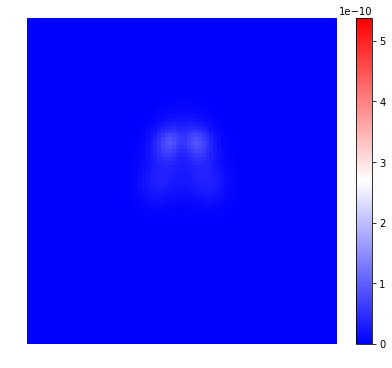

-1.11022302463e-16
1.48039312783e-10
5.57051475544e-33


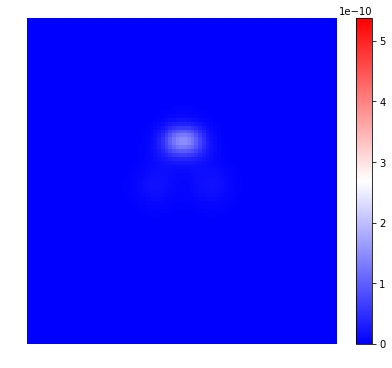

0.05
3.32002941505e-10
1.87598650796e-33


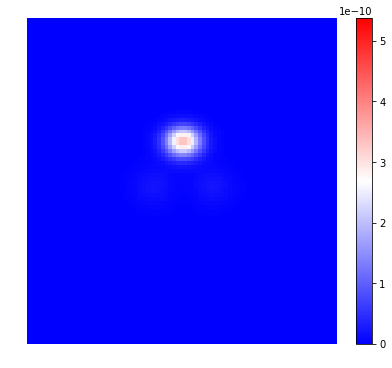

0.1
3.08573096502e-10
4.7567542821e-33


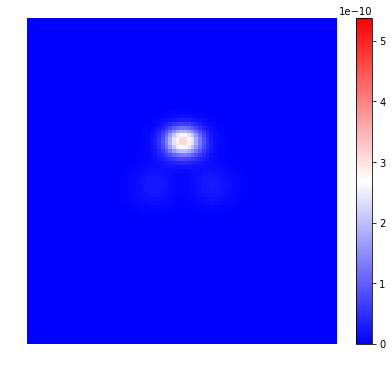

0.15
1.82211132616e-10
1.6048321519e-32


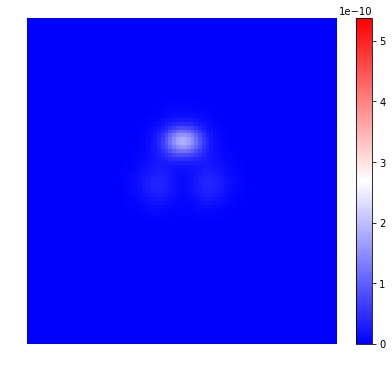

0.2
4.04048843917e-10
2.92838937575e-32


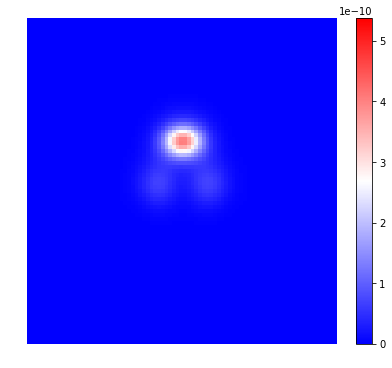

0.25
5.38247132553e-10
3.1753764085e-32


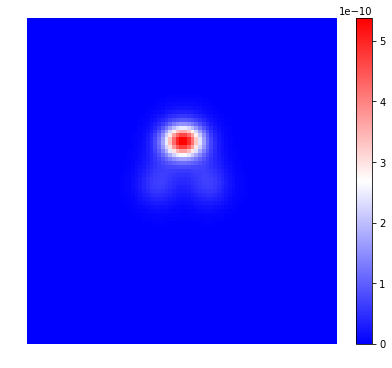

0.3
2.41600365892e-10
2.43705043919e-32


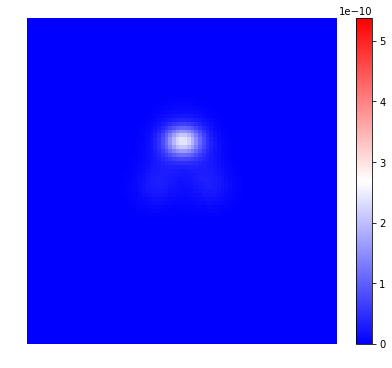

0.35
1.27929430824e-10
2.16766307679e-32


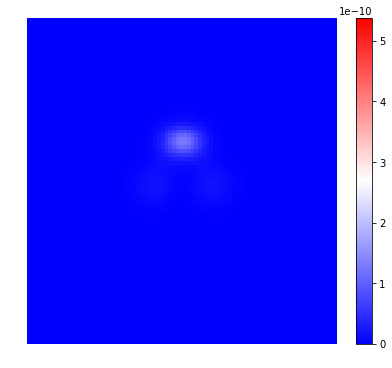

0.4
1.87565829425e-10
2.06804276246e-32


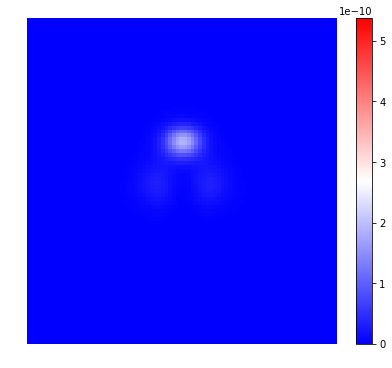

0.45
3.32121982159e-10
2.32876691503e-32


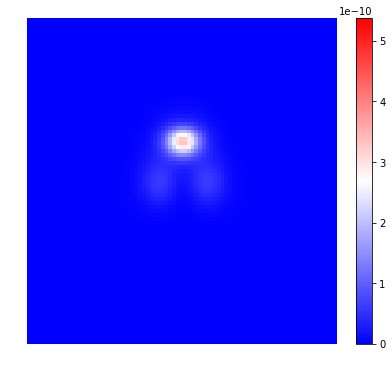

0.5
3.35117489128e-10
2.06134071036e-32


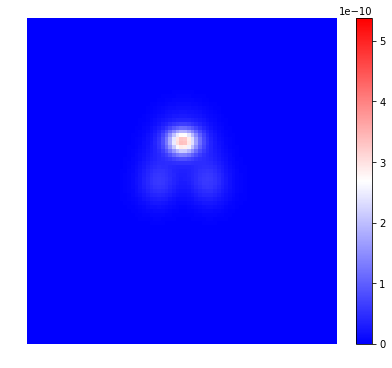

In [558]:
for i in range(len(e_arr)):
    print(e_arr[i])
    plt.figure(figsize=(eval_reg_size[1]/eval_reg_size[0]*6+1, 6))
    plot_data = pldos[:, :, i].T

    max_val = np.max(pldos)
    min_val = np.min(pldos)
    
    print(np.max(plot_data))
    print(np.min(plot_data))

    plt.pcolormesh(plot_data, vmax=max_val, vmin=min_val, cmap='bwr')
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [552]:
np.shape(pldos)

(83, 82, 21)

In [554]:
np.max(pldos)

0.00010330229907558793